# Irradiance time series for single pixel

This notebook plots the time series of irradiance values for a single pixel, based on a given set of lat/lon coordinates, for a given number of days

In [1]:
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import cartopy.crs as ccrs
import pandas as pd

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [2]:
# coordinates = (-33.9, 151.2) # Sydney
# coordinates = (-37.8, 145.0) # Melbourne
coordinates = (-27.5, 153.0) # Brisbane
# coordinates = (-34.9, 138.6) # Adelaide

num_days = 10

# UTC datetime
year = 2018
month = 5
day = 15
hour = 18
minute = 30
utc_dt = datetime(year, month, day, hour, minute)

# data files are iterated through, and the irradiance for the corresponding coordinate added to this list
ghi_data = []

# Because loop uses simple "for i in range()", and time slices are not consistent between days (i.e. no data overnight, so big jump each day),
# the next data file must be found manually by incrementing the datetime value at the end of each iteration
for i in range(103*num_days): # 103 ten min segments per day

    # Find datetime for each data file,
    # taking into account difference in datetime between file names (UTC) and the daily directories the files are sorted into (AUS time)
    file_dt = utc_dt.strftime("%Y%m%d%H%M")
    dir_dt = utc_dt + timedelta(hours=5, minutes=30)
    filename='IDE00326.'+file_dt+'.nc'

    if utc_dt >= datetime(2019, 4, 1, 0):
        folder = 'latest'
    else:
        folder = 'v1.0'
    dirin = f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/{folder}/{dir_dt.year:04}/{dir_dt.month:02}/{dir_dt.day:02}/'
    
    # dirin='/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/'+f"{dir_dt.year:04}"+'/'+f"{dir_dt.month:02}"+'/'+f"{dir_dt.day:02}"+"/"

    # try/except block so code does not crash if there is a missing data file (missing files are common)
    try:
        dataset = Dataset(dirin+filename)
        
        # Read the variables
        latitudes = dataset.variables['latitude'][:]
        longitudes = dataset.variables['longitude'][:]

        # use given coordinate values to find the indices of those coordinates
        coord_indices = (
            np.where(latitudes == coordinates[0])[0][0],
            np.where(longitudes == coordinates[1])[0][0]
        )
        
        # use the coordinate indices to find the corresponding irradiance value
        irradiance = dataset.variables['surface_global_irradiance'][:,coord_indices[0], coord_indices[1]].data[0]
        # All good data is greater than zero.
        # Masked values default to -99999, so set these values to np.nan
        if irradiance > 0:
            ghi_data.append(irradiance)
        else:
            ghi_data.append(np.nan)
            
    except FileNotFoundError:
        print(f"File not found: {dirin + filename}.")
        dataset = None

    # Manually adjusting the datetime variable to find the next file on the next iteration.
    # Normal timesteps are ten minutes (data also available for 1 hour and 1 day steps).
    # Final UTC time is 1130, and first UTC time in the next file is 7 hours ahead.
    if file_dt[-4:] == '1130':
        utc_dt = utc_dt + timedelta(hours=7)
    else:
        utc_dt = utc_dt + timedelta(minutes=10)

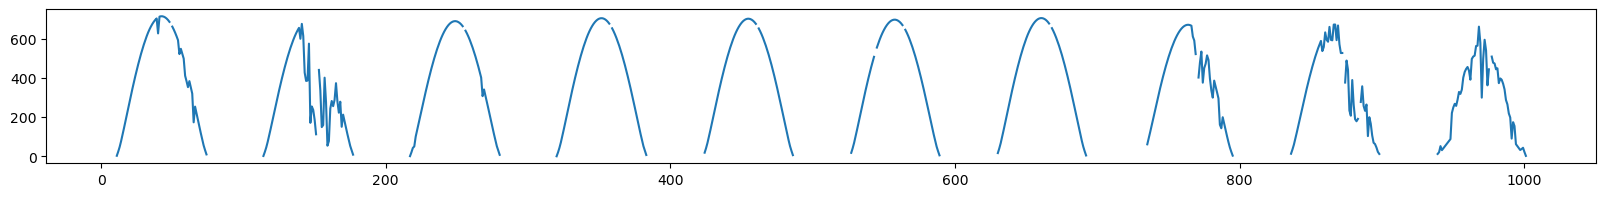

In [6]:
plt.figure(figsize=(20,2))
plt.plot(ghi_data)